# Shadow Model<br>
This model will be trained on *target.pth* that was created in *Model.ipynb*. <br>
<br>
This next code block runs all the dependancies and boilerplate.<br>
To view the logic behind this code go to *Model.ipynb*.

In [38]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
assert(torch.cuda.is_available())

# make the class for the model
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28 * 28, 64)
        self.l2 = nn.Linear(64,64)
        self.l3 = nn.Linear(64, 10)
        self.do = nn.Dropout(0.1)
    
    def forward(self,x):
        h1 = nn.functional.relu(self.l1(x))
        h2 = nn.functional.relu(self.l2(h1))
        do = self.do(h2 + h1)
        logits = self.l3(do)
        return logits
    
# import the target model
target = Model().cuda()
target.load_state_dict(torch.load('target.pth'))

# load the data, and create the loss function
data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
# the split here is not needed, but I still want to validate that the model is working, and not run the entire dataset
_, test = random_split(data, [50000, 10000])
test_loader = DataLoader(test, batch_size=32)
loss = nn.CrossEntropyLoss()

### Verify Target Model Works<br>
This loop runs through the target model on a subset of the data, just to test that it loaded in properly.

In [39]:
accuracy = []
for batch in test_loader:
    x, y = batch
    batch_size = x.size(0)
    x = x.view(batch_size, -1).cuda()

    
    with torch.no_grad():
      logit = target(x)
    objective = loss(logit, y.cuda())
    accuracy.append(y.eq(logit.detach().argmax(dim=1).cpu()).float().mean())


print(f'Target accuracy: {torch.tensor(accuracy).mean():.2f}')

Target accuracy: 0.93


## Training the shadow model<br>
First we split the data into the different sets and create data loaders

In [40]:
train, val = random_split(data, [55000, 5000])
val, test = random_split(val, [4000, 1000])
val_for_target = DataLoader(val, batch_size=32)
train_for_target = DataLoader(train, batch_size=32)
test_loader = DataLoader(test, batch_size=32)

shadow = Model().cuda()


optimiser = optim.SGD(shadow.parameters(), lr=1e-2)
loss = nn.CrossEntropyLoss()


### Image printer for seeing the data as an image<br>
This function is used later to show the imput images to us so we can view them.

In [41]:
def show_image(image, label, pred):
    image_np = image.squeeze().numpy()
    plt.imshow(image_np, cmap='gray')
    plt.title(f"Actual: {label.item()}, Predicted: {pred}")
    plt.axis('off')
    plt.show()

## Training loop for shadow model<br>

This loop is almost the same as the main loop except for one key thing.<br>
The labels (*t*) are ignored and the labels are then obtained by feeding the inputs into the target model.

In [42]:
num_epoch = 5
for epoch in range(num_epoch):
  losses = []

  for batch in train_for_target:
    #we shouldn't use the labels from the data
    image, t = batch
    
    # here is where the two models differ, we use the target model to generate the labels
    lables = target(image.cuda().view(image.size(0), -1)).argmax(dim=1)

    # the rest of the code is essentially the same
    batch_size = image.size(0)
    image = image.view(batch_size, -1).cuda()
    logit = shadow(image)
    objective = loss(logit, lables.cuda())
    shadow.zero_grad()
    objective.backward()
    optimiser.step()
    losses.append(objective.item())

  accuracy = []
  for batch in val_for_target:
    x, y = batch
    batch_size = x.size(0)

    x = x.view(batch_size, -1).cuda()
    with torch.no_grad():
      logit = shadow(x)
    objective = loss(logit, y.cuda())
    accuracy.append(y.eq(logit.detach().argmax(dim=1).cpu()).float().mean())

  print(f'Epoch {epoch + 1}, validation accuracy: {torch.tensor(accuracy).mean():.2f}')

Epoch 1, validation accuracy: 0.87
Epoch 2, validation accuracy: 0.89
Epoch 3, validation accuracy: 0.90
Epoch 4, validation accuracy: 0.90
Epoch 5, validation accuracy: 0.91


## Validating the Shadow Model<br>
### viewing examples of incorrectly labeled data<br>
Below is a loop to test the target data, then I print 10 examples of where the model messed up so we can see where it was confused.

Shadow model accuracy: 0.92


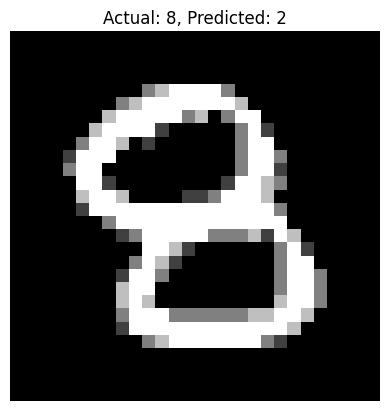

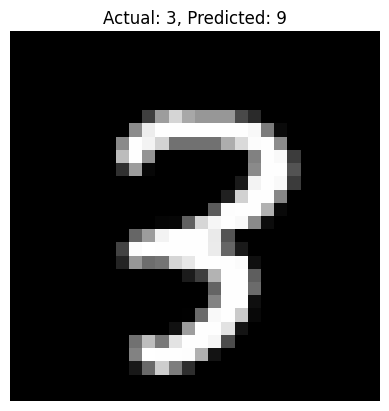

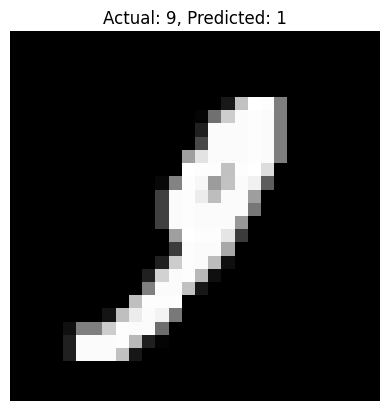

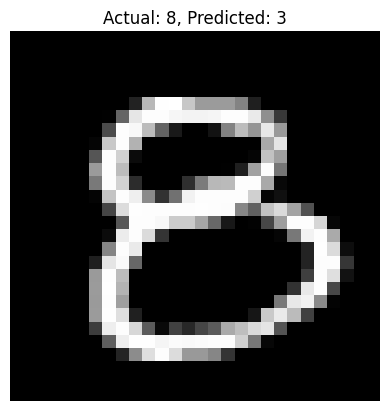

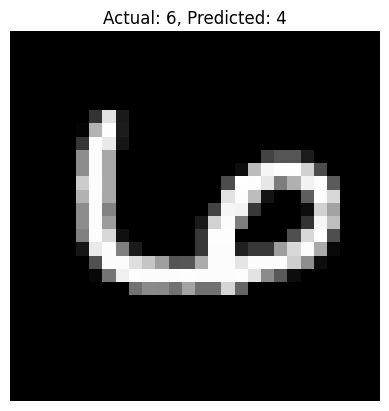

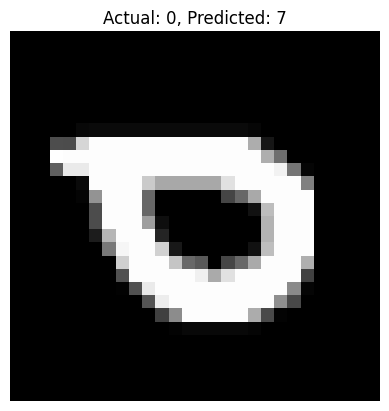

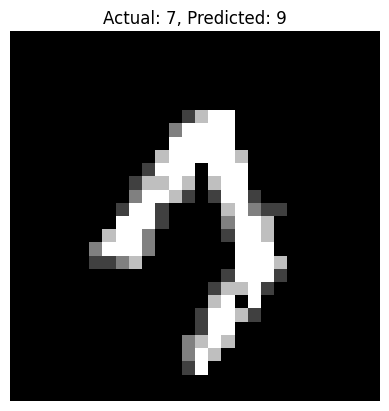

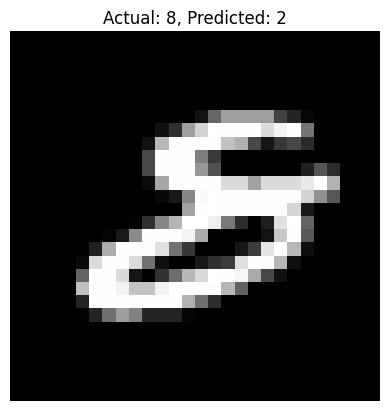

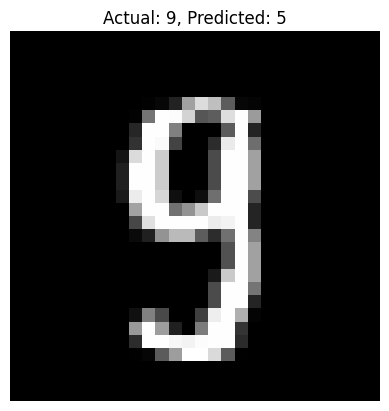

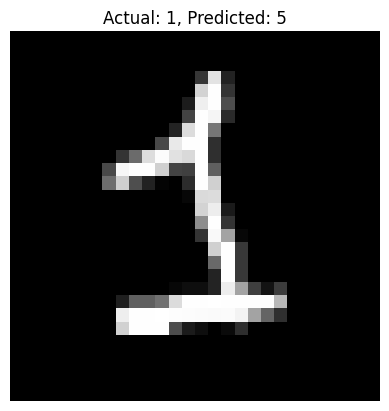

In [43]:

class image_obj:
    def __init__(self, image, label, prediction):
        self.image = image
        self.label = label
        self.prediction = prediction

incorrect_images = []

for batch in test_loader:
    img, y = batch
    batch_size = img.size(0)
    x = img.view(batch_size, -1).cuda()
    with torch.no_grad():
      logit = shadow(x)
    predicted = logit.argmax(dim=1)
    for i in range(32):
        # try catch is here because the last batch might not have 32 images
        try:
            if predicted[i] != y[i]:
                incorrect_images.append(image_obj(img[i], y[i], predicted[i]))
        except:
            pass

accuracy = 1 - len(incorrect_images) / 1000
print(f"Shadow model accuracy: {accuracy:.2f}")

for i in range(10):
    show_image(incorrect_images[i].image, incorrect_images[i].label, incorrect_images[i].prediction.item())
    



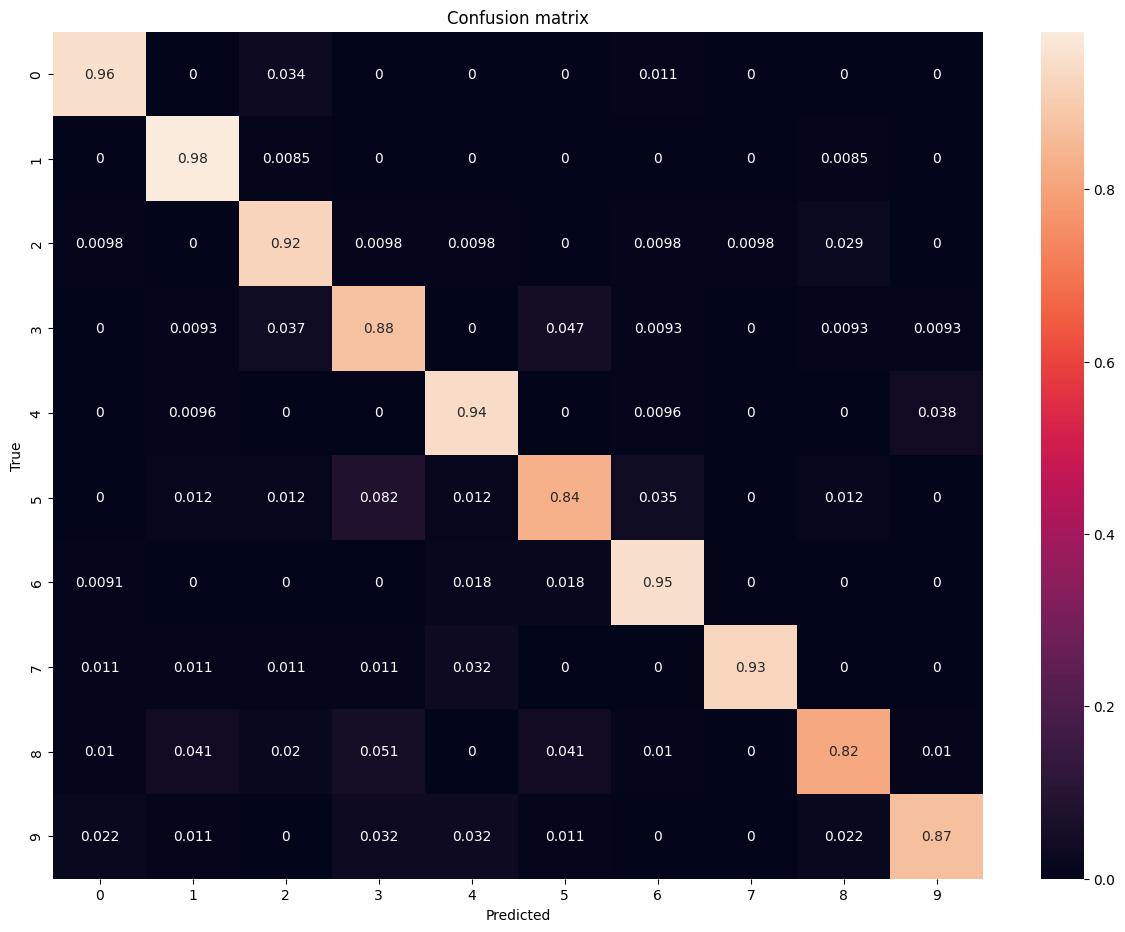

Overall accuracy: 91.10%


In [44]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np

y_pred = []
y_true = []
for batch in test_loader:
        x, y = batch
        batch_size = x.size(0)
        x = x.view(batch_size, -1).cuda()
        with torch.no_grad():
          logit = shadow(x)

        output = (torch.max(torch.exp(logit), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        y = y.data.cpu().numpy()
        y_true.extend(y)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None], index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (15,11))
plt.title('Confusion matrix')
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('Overall accuracy: {:.2f}'.format((np.trace(cm) / np.sum(cm)) * 100) + '%')